## Setup (first 3 blocks for google colab)

In [0]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

tcmalloc: large alloc 1073750016 bytes == 0x5bcec000 @  0x7fd299dc42a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [0]:
# mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# colab needs version 4.1.1
!pip install torchvision
!pip install Pillow==4.1.1
!pip install image

    100% |████████████████████████████████| 5.7MB 6.4MB/s 
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
    100% |████████████████████████████████| 7.3MB 5.7MB/s 


In [0]:
# load libraries
import torch
import torch.nn as nn
from torch.nn import functional as F

import torchvision.transforms as T
from torchvision import models

import io
import requests
import numpy as np
import PIL
from PIL import Image
import cv2

# from scipy.misc import imresize
from collections import namedtuple
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 0
%matplotlib inline

## Load data and model

In [2]:
# input image
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
IMG_URL = 'http://media.mlive.com/news_impact/photo/9933031-large.jpg'

# networks such as googlenet, resnet, densenet already use global average pooling at the end, so CAM could be used directly.
model_id = 1
if model_id == 1:
    net = models.squeezenet1_1(pretrained=True)
elif model_id == 2:
    net = models.resnet50(pretrained=True)
elif model_id == 3:
    net = models.densenet161(pretrained=True)

dtype = torch.cuda.FloatTensor

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.cache/torch/checkpoints/squeezenet1_1-f364aa15.pth
100%|██████████| 4.74M/4.74M [00:00<00:00, 9.89MB/s]


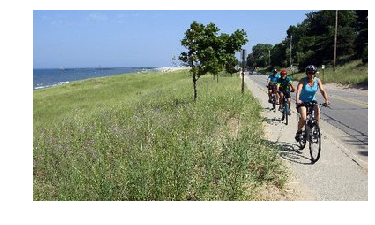

In [3]:
# fetch the image from the url
response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))   # (216, 380)

plt.axis('off')
plt.imshow(img_pil)

## Obtain output tensor of each layer and final logit

In [4]:
# get the softmax weight, for calculating CAMs
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].cpu().data.numpy())
weight_softmax.shape

(1000, 512)

In [5]:
# preprocess input images
def preprocess(img):
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)


# feature extractor
def extract_features(x, model):
    """
    Use the CNN to extract features from the input image x.
    
    Inputs:
    - x: A PyTorch Tensor of shape (N, C, H, W) holding a minibatch of images that
      will be fed to the CNN.
    - model: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of feature for the input images x extracted using the cnn model.
      features[i] is a PyTorch Tensor of shape (N, C_i, H_i, W_i); recall that features
      from different layers of the network may have different numbers of channels (C_i) and
      spatial dimensions (H_i, W_i).
    """
    features = []
    prev_feat = x
    for i, module in enumerate(model._modules.values()):
        next_feat = module(prev_feat)
        features.append(next_feat.cpu().detach().numpy())
        prev_feat = next_feat
    return features


net.type(dtype)
net.eval()
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
logit = net(img_tensor)   # (1, 1000)

features_blobs = extract_features(img_tensor, net.features)
print('Final output tensor shape (before classifer):', features_blobs[-1].shape)

Final output tensor shape (before classifer): (1, 512, 13, 13)


In [0]:
# download the imagenet category list
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

h_x = F.softmax(logit, dim=1).data.squeeze()   # (1000,) probability of each class for this image
probs, idx = h_x.sort(0, True)
probs = probs.cpu().numpy()
idx = idx.cpu().numpy()

In [7]:
# output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

0.678 -> mountain bike, all-terrain bike, off-roader
0.088 -> bicycle-built-for-two, tandem bicycle, tandem
0.042 -> unicycle, monocycle
0.038 -> horse cart, horse-cart
0.019 -> lakeside, lakeshore


In [0]:
def imresize(img, size):
    im = Image.fromarray(img)
    return np.array(im.resize(size, PIL.Image.BICUBIC))

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps (CAMs) upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(imresize(cam_img, size_upsample))
    return output_cam

# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[-1], weight_softmax, [idx[0], idx[4]])

In [0]:
CAMs[0].shape

(256, 256)

## Render the output  CAM

In [0]:
# heatmap from cv2
print('output for the top-1 prediction: %s'%classes[idx[0]])

width, height = img_pil.size
heatmap = cv2.resize(CAMs[0],(width, height))   # (216, 380)
# heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)   # (216, 380, 3)

output for the top-1 prediction: mountain bike, all-terrain bike, off-roader


In [0]:
## mountain bike
# heatmap and result from PIL
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))   # (216, 380)

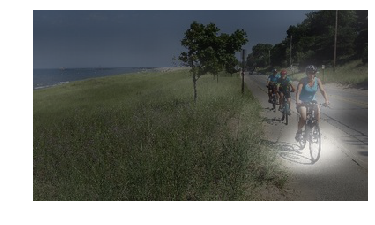

In [0]:
result = (heatmap[:,:,None] * 0.65 + np.array(img_pil) * 0.35).astype(np.uint8)
plt.axis('off')
plt.imshow(result)
plt.show()

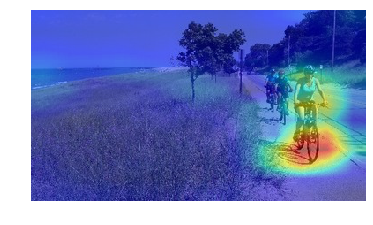

In [0]:
plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
#plt.colorbar()
plt.show()

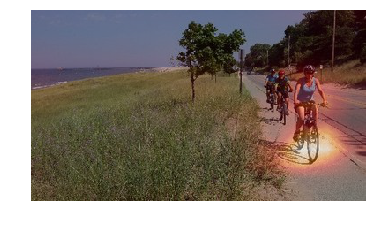

In [0]:
plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='gist_heat', alpha=0.4)
#plt.colorbar()
plt.show()

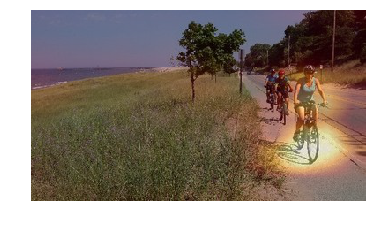

In [0]:
plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='afmhot', alpha=0.4)
#plt.colorbar()
plt.show()

In [0]:
## lakeside
# heatmap and result from PIL
heatmap = imresize(CAMs[1], (width, height))   # (216, 380)

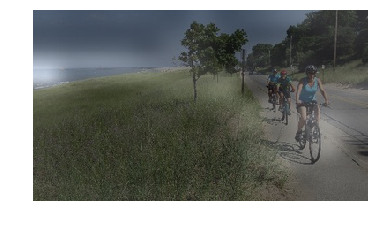

In [11]:
result = (heatmap[:,:,None] * 0.65 + np.array(img_pil) * 0.35).astype(np.uint8)
plt.axis('off')
plt.imshow(result)
plt.show()

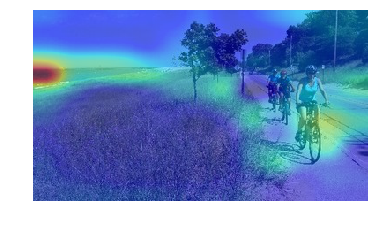

In [12]:
plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
#plt.colorbar()
plt.show()

## ResNet-50 result

In [0]:
# input image
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
IMG_URL = 'http://media.mlive.com/news_impact/photo/9933031-large.jpg'

# networks such as googlenet, resnet, densenet already use global average pooling at the end, so CAM could be used directly.
model_id = 2
if model_id == 1:
    net = models.squeezenet1_1(pretrained=True)
elif model_id == 2:
    net = models.resnet50(pretrained=True)
elif model_id == 3:
    net = models.densenet161(pretrained=True)

dtype = torch.cuda.FloatTensor

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:05<00:00, 17475799.95it/s]


In [0]:
# get the softmax weight, for calculating CAMs
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].cpu().data.numpy())
weight_softmax.shape

(1000, 2048)

In [0]:
# feature extractor
def extract_features(x, model):
    """
    Use the CNN to extract features from the input image x.
    
    Inputs:
    - x: A PyTorch Tensor of shape (N, C, H, W) holding a minibatch of images that
      will be fed to the CNN.
    - model: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of feature for the input images x extracted using the cnn model.
      features[i] is a PyTorch Tensor of shape (N, C_i, H_i, W_i); recall that features
      from different layers of the network may have different numbers of channels (C_i) and
      spatial dimensions (H_i, W_i).
    """
    features = []
    prev_feat = x
    for module_name in list(net._modules.keys())[:-2]:
        next_feat = net._modules[module_name](prev_feat)
        features.append(next_feat.cpu().detach().numpy())
        prev_feat = next_feat
    return features

net.type(dtype)
net.eval()
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
logit = net(img_tensor)   # (1, 1000)

features_blobs = extract_features(img_tensor, net)
print('Final output tensor shape (before classifer):', features_blobs[-1].shape)

Final output tensor shape (before classifer): (1, 2048, 7, 7)


In [0]:
# download the imagenet category list
h_x = F.softmax(logit, dim=1).data.squeeze()   # (1000,) probability of each class for this image
probs, idx = h_x.sort(0, True)
probs = probs.cpu().numpy()
idx = idx.cpu().numpy()

In [0]:
# output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

0.491 -> mountain bike, all-terrain bike, off-roader
0.219 -> bicycle-built-for-two, tandem bicycle, tandem
0.143 -> unicycle, monocycle
0.054 -> lakeside, lakeshore
0.034 -> seashore, coast, seacoast, sea-coast


In [0]:
# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[-1], weight_softmax, [idx[0]])

width, height = img_pil.size
heatmap = imresize(CAMs[0], (height, width))
heatmap.shape

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


(216, 380)

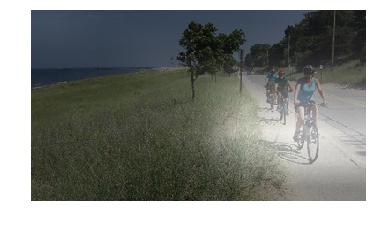

In [0]:
result = (heatmap[:,:,None] * 0.65 + np.array(img_pil) * 0.35).astype(np.uint8)
plt.axis('off')
plt.imshow(result)
plt.show()

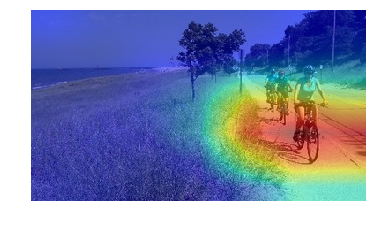

In [0]:
# ResNet-50
plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
#plt.colorbar()
plt.show()

## DenseNet-161 result

In [0]:
# input image
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
IMG_URL = 'http://media.mlive.com/news_impact/photo/9933031-large.jpg'

# networks such as googlenet, resnet, densenet already use global average pooling at the end, so CAM could be used directly.
model_id = 3
if model_id == 1:
    net = models.squeezenet1_1(pretrained=True)
elif model_id == 2:
    net = models.resnet50(pretrained=True)
elif model_id == 3:
    net = models.densenet161(pretrained=True)

dtype = torch.cuda.FloatTensor

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.torch/models/densenet161-8d451a50.pth
100%|██████████| 115730790/115730790 [00:05<00:00, 23106879.15it/s]


In [0]:
# get the softmax weight, for calculating CAMs
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].cpu().data.numpy())
weight_softmax.shape

(1000, 2208)

In [0]:
# feature extractor
def extract_features(x, model):
    """
    Use the CNN to extract features from the input image x.
    
    Inputs:
    - x: A PyTorch Tensor of shape (N, C, H, W) holding a minibatch of images that
      will be fed to the CNN.
    - model: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of feature for the input images x extracted using the cnn model.
      features[i] is a PyTorch Tensor of shape (N, C_i, H_i, W_i); recall that features
      from different layers of the network may have different numbers of channels (C_i) and
      spatial dimensions (H_i, W_i).
    """
    features = []
    prev_feat = x
    for module in model._modules.values():
        next_feat = module(prev_feat)
        features.append(next_feat.cpu().detach().numpy())
        prev_feat = next_feat
    next_feat = F.relu(prev_feat)
    features[-1] = next_feat.cpu().detach().numpy()
    return features

net.type(dtype)
net.eval()
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
logit = net(img_tensor)   # (1, 1000)

features_blobs = extract_features(img_tensor, net.features)
print('Final output tensor shape (before classifer):', features_blobs[-1].shape)

Final output tensor shape (before classifer): (1, 2208, 7, 7)


In [0]:
# download the imagenet category list
h_x = F.softmax(logit, dim=1).data.squeeze()   # (1000,) probability of each class for this image
probs, idx = h_x.sort(0, True)
probs = probs.cpu().numpy()
idx = idx.cpu().numpy()

In [0]:
# output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

0.697 -> mountain bike, all-terrain bike, off-roader
0.180 -> bicycle-built-for-two, tandem bicycle, tandem
0.056 -> unicycle, monocycle
0.021 -> seashore, coast, seacoast, sea-coast
0.016 -> alp


In [0]:
# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[-1], weight_softmax, [idx[0]])

width, height = img_pil.size
heatmap = imresize(CAMs[0], (height, width))
heatmap.shape

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


(216, 380)

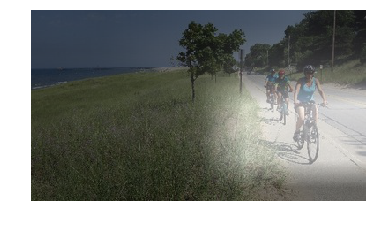

In [0]:
result = (heatmap[:,:,None] * 0.65 + np.array(img_pil) * 0.35).astype(np.uint8)
plt.axis('off')
plt.imshow(result)
plt.show()

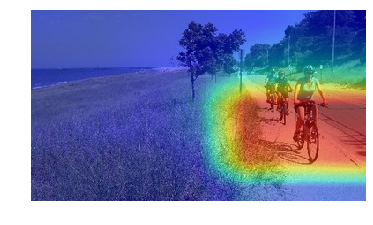

In [0]:
# DenseNet-161
plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
#plt.colorbar()
plt.show()

## Inception-v3 result

In [0]:
# input image
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
IMG_URL = 'http://media.mlive.com/news_impact/photo/9933031-large.jpg'

# networks such as googlenet, resnet, densenet already use global average pooling at the end, so CAM could be used directly.
net = models.inception_v3(pretrained=True)

dtype = torch.cuda.FloatTensor

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.torch/models/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:02<00:00, 42099155.81it/s]


In [0]:
# get the softmax weight, for calculating CAMs
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].cpu().data.numpy())
weight_softmax.shape

(1000, 2048)

In [0]:
# preprocess input images
def preprocess(img):
    transform = T.Compose([
        T.Resize((299, 299)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)


# feature extractor
def extract_features(x, model):
    """
    Use the CNN to extract features from the input image x.
    
    Inputs:
    - x: A PyTorch Tensor of shape (N, C, H, W) holding a minibatch of images that
      will be fed to the CNN.
    - model: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of feature for the input images x extracted using the cnn model.
      features[i] is a PyTorch Tensor of shape (N, C_i, H_i, W_i); recall that features
      from different layers of the network may have different numbers of channels (C_i) and
      spatial dimensions (H_i, W_i).
    """
    features = []
    prev_feat = x
    for module_name in list(model._modules.keys())[:3]:
        next_feat = model._modules[module_name](prev_feat)
        features.append(next_feat.cpu().detach().numpy())
        prev_feat = next_feat
    next_feat = F.max_pool2d(prev_feat, kernel_size=3, stride=2)
    features.append(next_feat.cpu().detach().numpy())
    prev_feat = next_feat
    for module_name in list(model._modules.keys())[3:5]:
        next_feat = model._modules[module_name](prev_feat)
        features.append(next_feat.cpu().detach().numpy())
        prev_feat = next_feat
    next_feat = F.max_pool2d(prev_feat, kernel_size=3, stride=2)
    features.append(next_feat.cpu().detach().numpy())
    prev_feat = next_feat
    for module_name in list(model._modules.keys())[5:-5]:
        next_feat = model._modules[module_name](prev_feat)
        features.append(next_feat.cpu().detach().numpy())
        prev_feat = next_feat
    for module_name in list(model._modules.keys())[-4:-1]:
        next_feat = model._modules[module_name](prev_feat)
        features.append(next_feat.cpu().detach().numpy())
        prev_feat = next_feat
    return features


net.type(dtype)
net.eval()
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
logit = net(img_tensor)   # (1, 1000)

features_blobs = extract_features(img_tensor, net)
print('Final output tensor shape (before classifer):', features_blobs[-1].shape)

Final output tensor shape (before classifer): (1, 2048, 8, 8)


In [0]:
# download the imagenet category list
h_x = F.softmax(logit, dim=1).data.squeeze()   # (1000,) probability of each class for this image
probs, idx = h_x.sort(0, True)
probs = probs.cpu().numpy()
idx = idx.cpu().numpy()

In [0]:
# output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

0.820 -> bicycle-built-for-two, tandem bicycle, tandem
0.058 -> mountain bike, all-terrain bike, off-roader
0.022 -> lakeside, lakeshore
0.012 -> seashore, coast, seacoast, sea-coast
0.005 -> breakwater, groin, groyne, mole, bulwark, seawall, jetty


In [0]:
# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[-1], weight_softmax, [idx[0]])

width, height = img_pil.size
heatmap = imresize(CAMs[0], (height, width))
heatmap.shape

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


(216, 380)

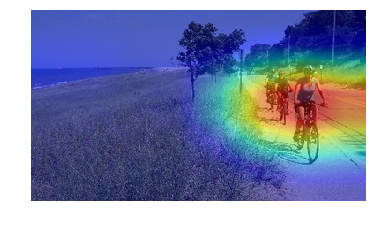

In [0]:
# Inception-v3
plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
#plt.colorbar()
plt.show()

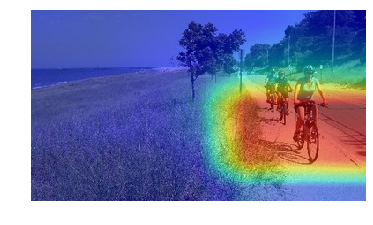

In [0]:
# DenseNet-161
plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
#plt.colorbar()
plt.show()

In [0]:
# ResNet-50
plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
#plt.colorbar()
plt.show()

In [0]:
# Squeezenet
plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
#plt.colorbar()
plt.show()

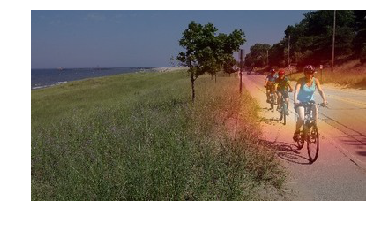

In [0]:
# Inception-v3
plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='gist_heat', alpha=0.4)
#plt.colorbar()
plt.show()

In [0]:
# DenseNet-161
plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='gist_heat', alpha=0.4)
#plt.colorbar()
plt.show()

In [0]:
# ResNet-50
plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='gist_heat', alpha=0.4)
#plt.colorbar()
plt.show()

In [0]:
# SqueezeNet
plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='gist_heat', alpha=0.4)
#plt.colorbar()
plt.show()